https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?form=MG0AV3

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() 

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "D:\git\FYP\Python\TwoStage\data\Pandora_7k\Pandora7k_split_70"


#data_dir = r"D:\git\FYP\Python\understanding\sample"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Function to train/validate a model for a single epoch
def run_epoch(model, dataloader, criterion, optimizer=None, scheduler=None, phase='train'):
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    image_names = []  # To store image names for confusion matrix
    
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() if optimizer else None
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        image_names.extend([x[0].split("\\")[-1] for x in dataloader.dataset.samples])
    
    if phase == 'train' and scheduler:
        scheduler.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    return epoch_loss, epoch_acc.item(), precision, recall, f1, image_names, all_labels, all_preds

# Function to calculate precision, recall, and F1 scores
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return precision, recall, f1

# Function to handle training and validation across epochs
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=50, patience=3):
    best_acc = 0.0
    epochs_no_improve = 0
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    best_epoch = 0
    all_image_data = []  # For storing predictions and true labels
    model_name='pandora7k_resnet50_80split.pt'
    
    #best_model_path = f'{model_name}.pth'
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n{"-"*10}')
        
        # Training and validation phases
        for phase in ['train', 'val']:
            dataloader = dataloaders[phase]
            optimizer_to_use = optimizer if phase == 'train' else None
            epoch_loss, epoch_acc, precision, recall, f1, image_names, true_labels, pred_labels = run_epoch(
                model, dataloader, criterion, optimizer_to_use, scheduler, phase
            )
            
            # Logging metrics
            if phase == 'train':
                train_metrics['accuracy'].append(epoch_acc)
                train_metrics['precision'].append(precision)
                train_metrics['recall'].append(recall)
                train_metrics['f1'].append(f1)
            else:
                val_metrics['accuracy'].append(epoch_acc)
                val_metrics['precision'].append(precision)
                val_metrics['recall'].append(recall)
                val_metrics['f1'].append(f1)
                
                # Track best accuracy and corresponding epoch
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch + 1  # Make sure to adjust for zero-based indexing (if applicable)
                    print(f"New best accuracy: {best_acc:.4f} at epoch {best_epoch}")

                    epochs_no_improve = 0
                    print(f"New best model found at epoch {best_epoch}, saving the entire model.")
                    torch.save(model, model_name)  # Save the entire model
                else:
                    epochs_no_improve += 1
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                    f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
            
            # Collect predictions and true labels for confusion matrix
            if phase == 'val':
                all_image_data.extend(zip(image_names, true_labels, pred_labels))
        
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
        print()
    
    # Load the best saved model
    if os.path.exists(model_name):
        model = torch.load(model_name)
        print(f"Best model loaded from {model_name}.")
    else:
        print("No model saved; returning the last trained model.")
    return model, train_metrics, val_metrics, all_image_data, best_epoch, best_acc


# Function to output metrics as a DataFrame
def metrics_to_df(train_metrics, val_metrics, best_epoch):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    metrics_df = pd.DataFrame({
        'Epoch': epochs,
        'Train Accuracy': train_metrics['accuracy'],
        'Val Accuracy': val_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Val Precision': val_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Val Recall': val_metrics['recall'],
        'Train F1 Score': train_metrics['f1'],
        'Val F1 Score': val_metrics['f1'],
    })
    metrics_df['Best Epoch'] = best_epoch
    return metrics_df

# Start training the model
model_ft, train_metrics, val_metrics, all_image_data, best_epoch, best_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=50, patience=3
)

# Convert metrics to DataFrame
metrics_df = metrics_to_df(train_metrics, val_metrics, best_epoch)
metrics_df['Best Accuracy'] = best_acc
metrics_df['Best Epoch'] = best_epoch
print(f"Metrics DataFrame:\n{metrics_df}")



Epoch 0/49
----------
Train Loss: 1.8462 Acc: 0.3714 Precision: 0.3605 Recall: 0.3714 F1: 0.3633
New best accuracy: 0.4961 at epoch 1
New best model found at epoch 1, saving the entire model.
Val Loss: 1.7256 Acc: 0.4961 Precision: 0.6357 Recall: 0.4961 F1: 0.4562

Epoch 1/49
----------
Train Loss: 1.5836 Acc: 0.4380 Precision: 0.4307 Recall: 0.4380 F1: 0.4331
New best accuracy: 0.5039 at epoch 2
New best model found at epoch 2, saving the entire model.
Val Loss: 1.5315 Acc: 0.5039 Precision: 0.5752 Recall: 0.5039 F1: 0.4783

Epoch 2/49
----------
Train Loss: 1.4126 Acc: 0.5031 Precision: 0.4963 Recall: 0.5031 F1: 0.4980
New best accuracy: 0.5965 at epoch 3
New best model found at epoch 3, saving the entire model.
Val Loss: 1.1623 Acc: 0.5965 Precision: 0.6253 Recall: 0.5965 F1: 0.5902

Epoch 3/49
----------
Train Loss: 1.2882 Acc: 0.5352 Precision: 0.5289 Recall: 0.5352 F1: 0.5305
New best accuracy: 0.6424 at epoch 4
New best model found at epoch 4, saving the entire model.
Val Loss: 

C:\Users\persad\AppData\Local\Temp\ipykernel_28804\889480455.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name)


In [20]:
import xlsxwriter
#Function to save predictions to Excel with class names instead of numerical labels
def save_predictions_to_excel(all_image_data, metrics_df, class_names, filename='model_output.xlsx'):
    # Map numerical class labels to class names
    all_image_data_named = [
        (image_name, class_names[true_class], class_names[pred_class]) 
        for image_name, true_class, pred_class in all_image_data
    ]
    
    predictions_df = pd.DataFrame(all_image_data_named, columns=['Image Name', 'True Class', 'Predicted Class'])
    predictions_df['Correct Prediction'] = predictions_df['True Class'] == predictions_df['Predicted Class']
    
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    print(f"Predictions and metrics saved to {filename}.")




# Save the predictions to Excel, including class names

save_predictions_to_excel(all_image_data, metrics_df, class_names, filename='model_output.xlsx')



Predictions and metrics saved to model_output.xlsx.


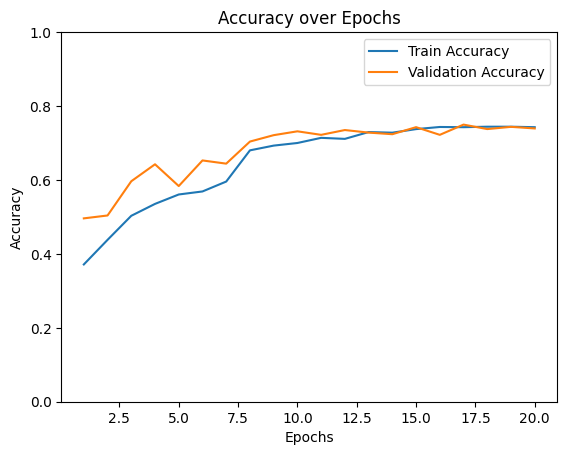

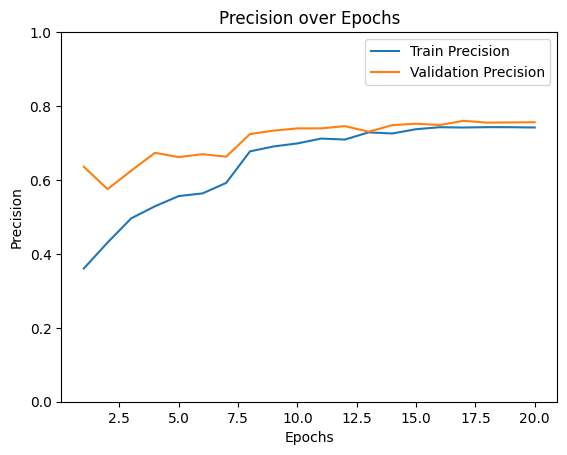

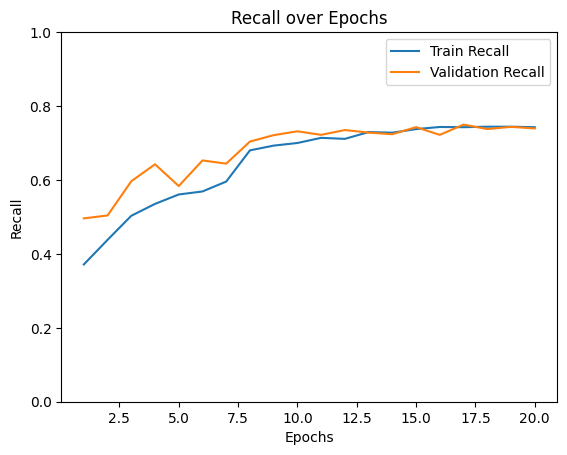

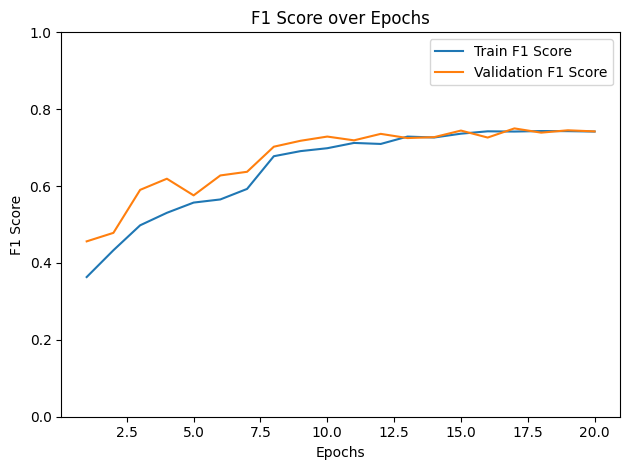

Training complete.


In [21]:
def plot_metrics_and_save(train_metrics, val_metrics, filename_prefix='metrics'):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    
    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_metrics['accuracy'], label='Train Accuracy')
    plt.plot(epochs, val_metrics['accuracy'], label='Validation Accuracy')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.savefig(f"{filename_prefix}_accuracy.png")
   

    # Plot Precision
    plt.figure()
    plt.plot(epochs, train_metrics['precision'], label='Train Precision')
    plt.plot(epochs, val_metrics['precision'], label='Validation Precision')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision over Epochs')
    plt.savefig(f"{filename_prefix}_precision.png")
 

    # Plot Recall
    plt.figure()
    plt.plot(epochs, train_metrics['recall'], label='Train Recall')
    plt.plot(epochs, val_metrics['recall'], label='Validation Recall')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall over Epochs')
    plt.savefig(f"{filename_prefix}_recall.png")


    # Plot F1 Score
    plt.figure()
    plt.plot(epochs, train_metrics['f1'], label='Train F1 Score')
    plt.plot(epochs, val_metrics['f1'], label='Validation F1 Score')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score over Epochs')
    plt.savefig(f"{filename_prefix}_f1_score.png")

    plt.tight_layout()
    plt.show()

# Plot and save metrics graphs
plot_metrics_and_save(train_metrics, val_metrics)

print("Training complete.")


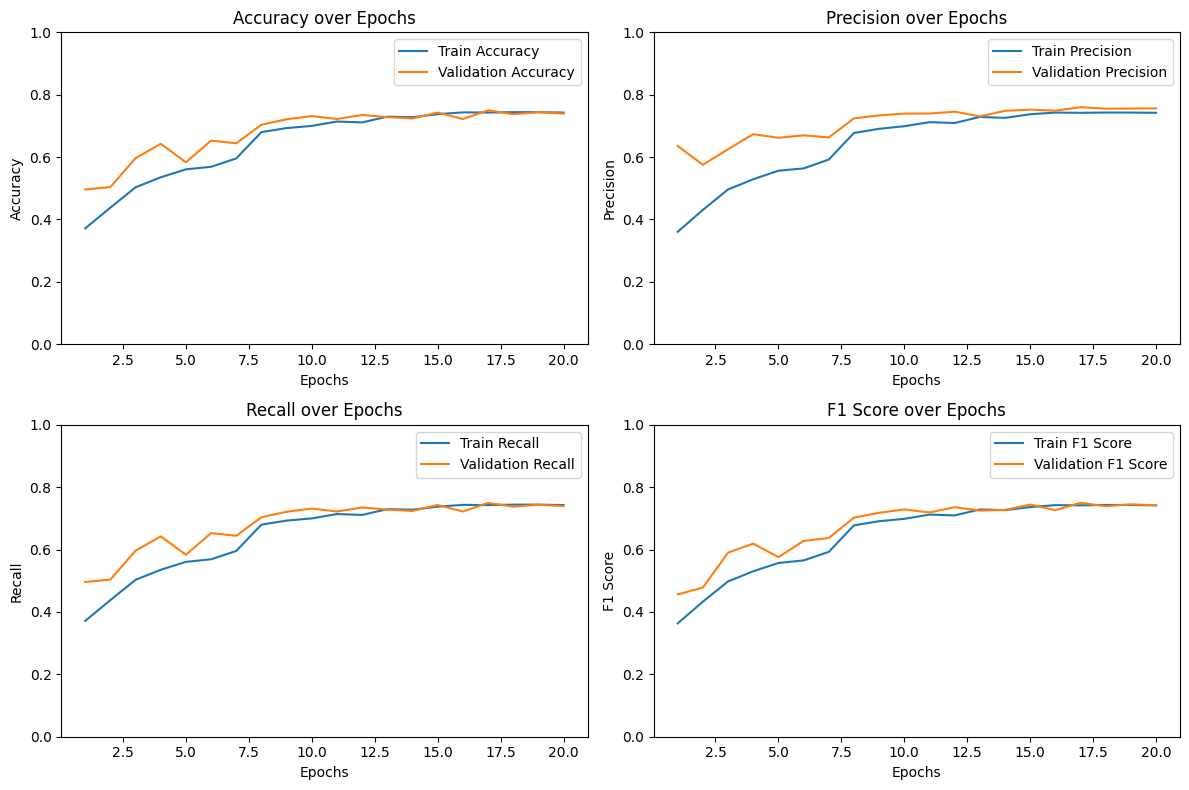

Training complete.


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_and_save(train_metrics, val_metrics, filename_prefix='metrics'):
    epochs = range(1, len(train_metrics['accuracy']) + 1)
    
    # Create a figure with a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot Accuracy
    axes[0, 0].plot(epochs, train_metrics['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(epochs, val_metrics['accuracy'], label='Validation Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].set_title('Accuracy over Epochs')

    # Plot Precision
    axes[0, 1].plot(epochs, train_metrics['precision'], label='Train Precision')
    axes[0, 1].plot(epochs, val_metrics['precision'], label='Validation Precision')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()
    axes[0, 1].set_title('Precision over Epochs')

    # Plot Recall
    axes[1, 0].plot(epochs, train_metrics['recall'], label='Train Recall')
    axes[1, 0].plot(epochs, val_metrics['recall'], label='Validation Recall')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].set_title('Recall over Epochs')

    # Plot F1 Score
    axes[1, 1].plot(epochs, train_metrics['f1'], label='Train F1 Score')
    axes[1, 1].plot(epochs, val_metrics['f1'], label='Validation F1 Score')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].set_title('F1 Score over Epochs')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a single image
    plt.savefig(f"{filename_prefix}_all_metrics.png")
    
    # Show the plots
    plt.show()

plot_metrics_and_save(train_metrics, val_metrics)

print("Training complete.")


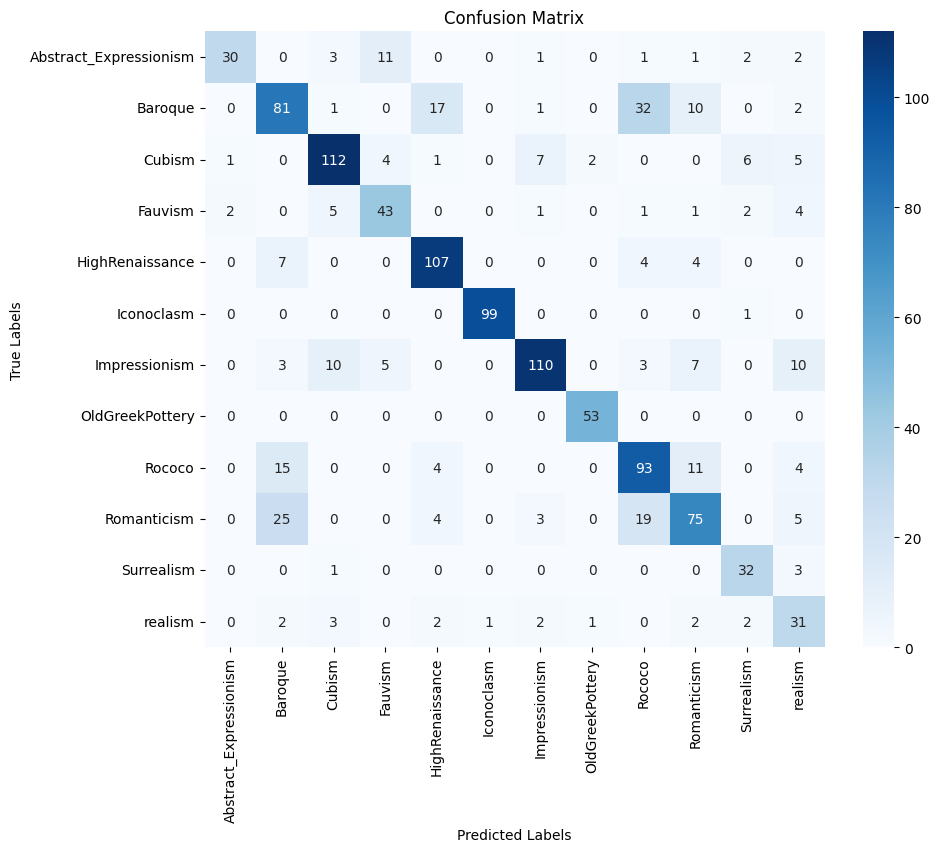

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and plot the confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    plt.show()

plot_confusion_matrix(model_ft, dataloaders['val'], class_names)


C:\Users\persad\AppData\Local\Temp\ipykernel_14944\24232532.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


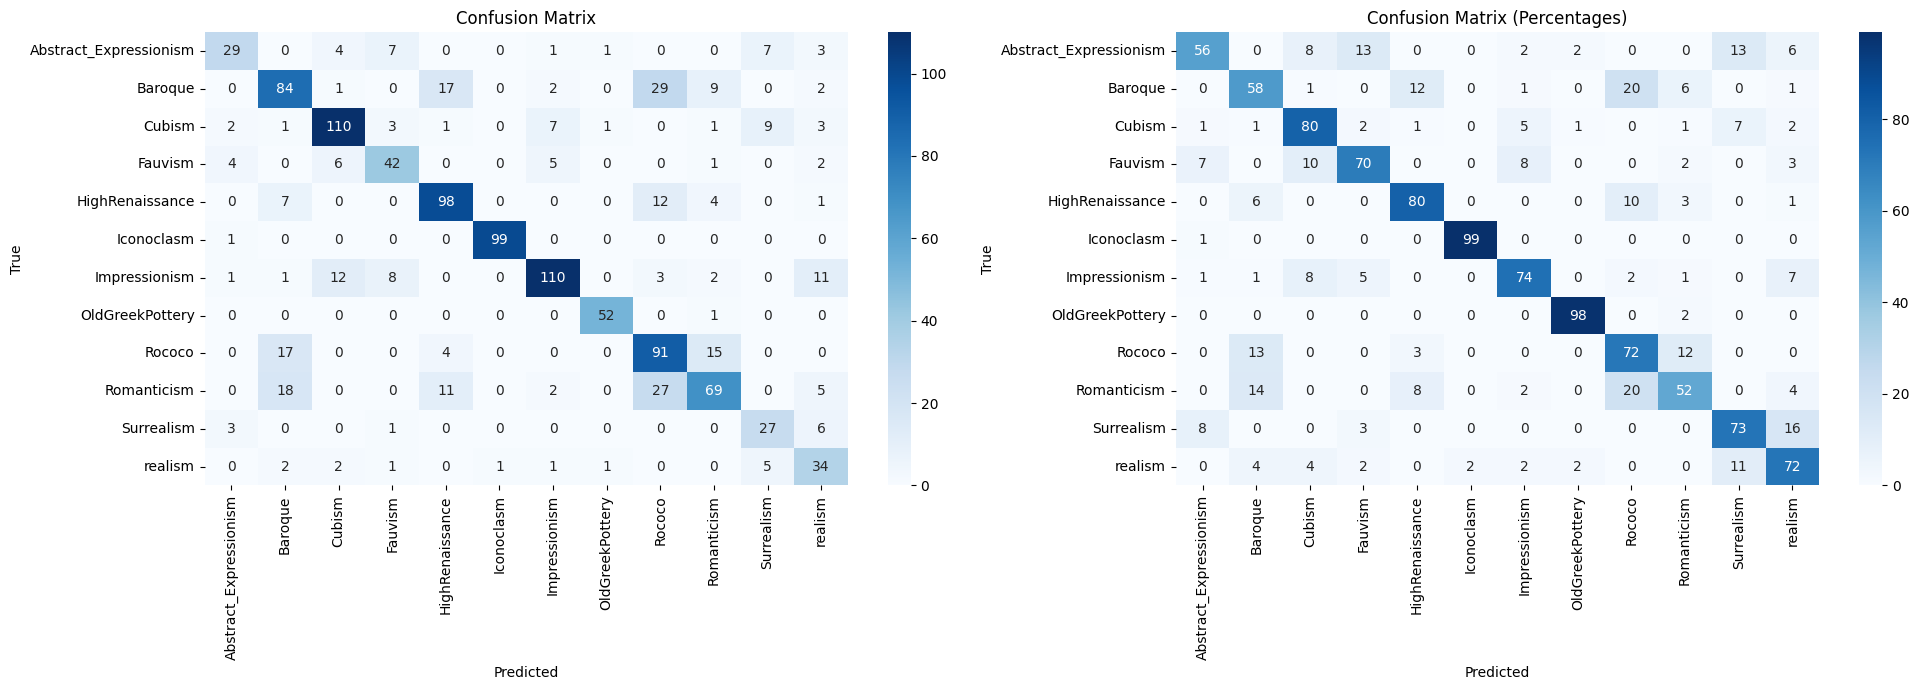

Overall Accuracy: 0.7284
                     Class  Precision  Recall  F1 Score  Accuracy  Support
0   Abstract_Expressionism      0.725   0.558     0.630     0.558     52.0
1                  Baroque      0.646   0.583     0.613     0.583    144.0
2                   Cubism      0.815   0.797     0.806     0.797    138.0
3                  Fauvism      0.677   0.700     0.689     0.700     60.0
4          HighRenaissance      0.748   0.803     0.775     0.803    122.0
5               Iconoclasm      0.990   0.990     0.990     0.990    100.0
6            Impressionism      0.859   0.743     0.797     0.743    148.0
7          OldGreekPottery      0.945   0.981     0.963     0.981     53.0
8                   Rococo      0.562   0.717     0.630     0.717    127.0
9              Romanticism      0.676   0.523     0.590     0.523    132.0
10              Surrealism      0.562   0.730     0.635     0.730     37.0
11                 realism      0.507   0.723     0.596     0.723     47.0


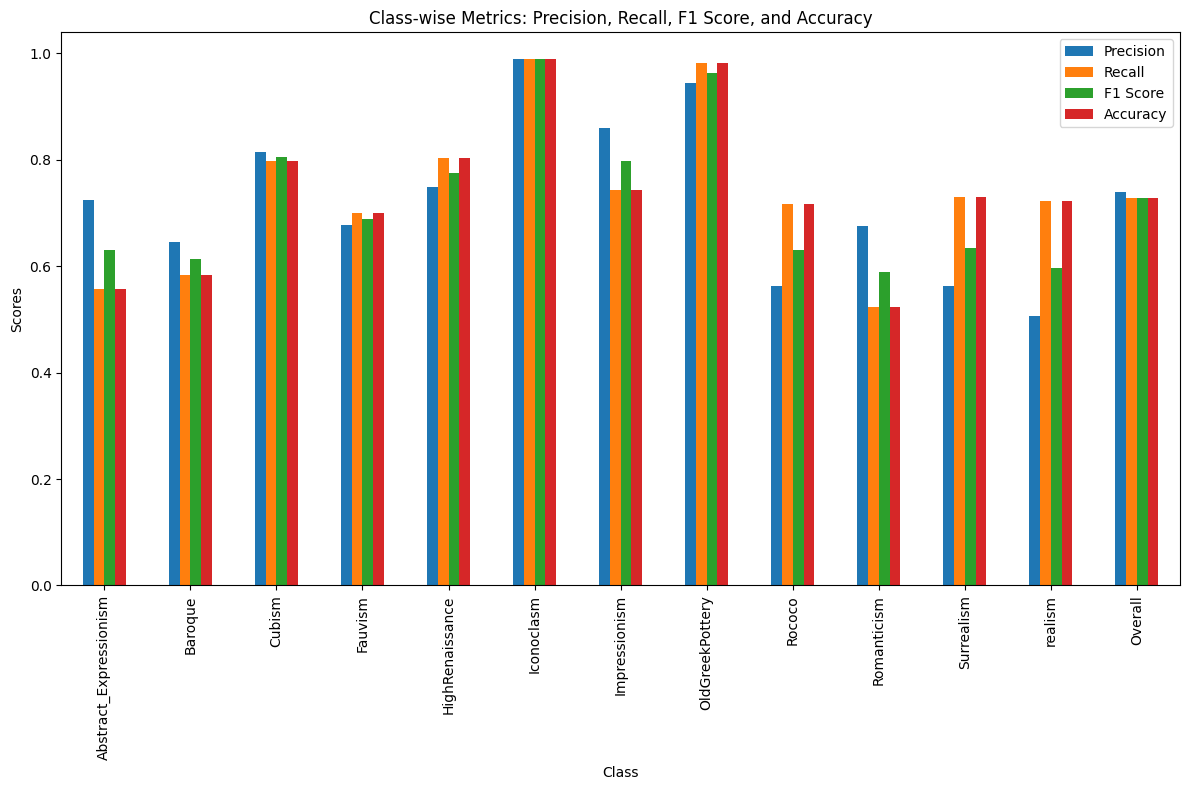

In [27]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define transformations for test data
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
data_dir = "D:/git/FYP/Python/TwoStage/data/Pandora_7k/Pandora7k_split_70"
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=4)
class_names = test_dataset.classes

# Load the trained model
model_path = 'pandora7k_resnet50_80split.pt'
model = torch.load(model_path)
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Convert to percentage form
# cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# # Plot the percentage confusion matrix
# plt.figure(figsize=(10,7))
# sns.heatmap(cm_percentage, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix (Percentages)')
# plt.show()
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert to percentage form
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a figure with two subplots (side by side)
plt.figure(figsize=(20, 7))

# Plot the confusion matrix (raw values)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Plot the confusion matrix (percentage values)
plt.subplot(1, 2, 2)
sns.heatmap(cm_percentage, annot=True, fmt='.0f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')

# Show both plots side by side
plt.tight_layout()
plt.show()


# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
#print(classification_report(all_labels, all_preds, target_names=class_names))

# Prepare metrics DataFrame with accuracy in a new column next to precision, recall, etc.
metrics = []
for idx, class_name in enumerate(class_names):
    class_metrics = report[class_name]
    class_accuracy = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    metrics.append([
        class_name,
        class_metrics['precision'],
        class_metrics['recall'],
        class_metrics['f1-score'],
        class_accuracy,  # Accuracy added here
        class_metrics['support']
    ])

# Add overall metrics
overall_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
overall_accuracy = accuracy_score(all_labels, all_preds)

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.4f}")

metrics.append([
    'Overall',
    overall_precision,
    overall_recall,
    overall_f1,
    overall_accuracy,  # Overall accuracy added here
    sum(report[class_name]['support'] for class_name in class_names)
])

# Create DataFrame with accuracy next to precision, recall, f1-score, and support
metrics_df = pd.DataFrame(metrics, columns=['Class', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'Support'])

# Round the values to 3 decimal places
metrics_df = metrics_df.round({'Precision': 3, 'Recall': 3, 'F1 Score': 3, 'Accuracy': 3})


# Debugging: Print the DataFrame to ensure accuracy is included
print(metrics_df)

# Excel file path
excel_path = 'Testing Outputs.xlsx'

# Write metrics and confusion matrix to separate sheets
with pd.ExcelWriter(excel_path) as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_excel(writer, sheet_name='Confusion Matrix')

print(f"Classification metrics and confusion matrix saved to {excel_path}")

# Visualization: Bar Plot for Precision, Recall, F1-Score, and Accuracy
metrics_df.set_index('Class')[['Precision', 'Recall', 'F1 Score', 'Accuracy']].plot(kind='bar', figsize=(12, 8))
plt.title('Class-wise Metrics: Precision, Recall, F1 Score, and Accuracy')
plt.ylabel('Scores')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()